# Πρόβλεψη δημοφιλίας βίντεο στο YouTube
#### *Μαριος Ζουμπουλογλου Α.Μ. 11022211 & Χρηστος Ξυπολοπουλος Α.Μ. 03003058*

Το dataset της εργασίας που επιλέξαμε προέρχεται από το [Kaggle](https://www.kaggle.com/datasnaek/youtube-new) και περιέχει πληροφοριές για τα βίντεο που ήταν δημοφιλή στην πλατφόρμα του Youtube. Περιλαμβάνει δεδομένα από αρκετές γεωγραφικές περιοχές και εκτείνετε σε δεδομένα αρκετών μηνών. 

Δεδομένου ότι η συλλογή περιέχει μόνο βίντεο τα οποία ήταν δημοφιλή έστω και για μια μέρα, δεν μπορούμε να το χρησιμοποιήσουμε για πρόβλεψη αν ένα βίντεο θα γίνει δημοφιλές. Παρ' όλα αυτά μπορούμε να το χρησιμοποιήσουμε για τους παρακάτω σκοπούς:

- **Task 1: Ανάλυση δημοφιλών βίντεο** ώστε να βρούμε κοινά χαρακτηριστικά που τα κάνουν δημοφιλή
- **Task 2: Πρόβλεψη κορυφαίων βίντεο** ώστε να προβλέψουμε τα βίντεο με τον μεγαλύτερο αριθμό προβολών
- **Task 3: Πρόβλεψη του αριθμών των προβολών** που θα λάβει ένα βίντεο

In [1]:
# Imports
from matplotlib import cm
from nltk.corpus import stopwords
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Load data from a specific country and print info 
countries = ['CA', 'GB', 'MX', 'IN', 'DE', 'RU', 'JP', 'FR', 'KR', 'US', "GB"]
videos_df = pd.DataFrame()
for country in countries:
    # Load the dataset for each country
    country_df = pd.read_csv("data/" + country + "videos.csv", index_col='video_id', encoding="latin")
    country_df['country'] = country
    
    # Replace category_id with the category title
    country_df["category_id"] = country_df["category_id"].astype(str)
    categories_df = pd.read_json("data/" + country + "_category_id.json")
    id_to_category = {category["id"]: category["snippet"]["title"] for category in categories_df["items"]}
    country_df['category'] = country_df['category_id'].replace(id_to_category)
    
    # Concat with previous datasets
    if videos_df.empty:
        videos_df = country_df
    else:
        videos_df = pd.concat([videos_df, country_df], ignore_index=True)
    
print("Dimensions:")
print(videos_df.shape)
print("Missing values:")
print(videos_df.isna().sum())
print("Column types:")
print(videos_df.dtypes)


Dimensions:
(414858, 17)
Missing values:
trending_date                 0
title                         0
channel_title                 0
category_id                   0
publish_time                  0
tags                          0
views                         0
likes                         0
dislikes                      0
comment_count                 0
thumbnail_link                0
comments_disabled             0
ratings_disabled              0
video_error_or_removed        0
description               20090
country                       0
category                      0
dtype: int64
Column types:
trending_date             object
title                     object
channel_title             object
category_id               object
publish_time              object
tags                      object
views                      int64
likes                      int64
dislikes                   int64
comment_count              int64
thumbnail_link            object
comments_disabled        

In [ ]:
## Εξερεύνηση του αρχικού dataset για όλα τα regions

Το dataset μας περιλαμβάνει **414.858 βίντεο** και το καθένα έχει **17 χαρακτηριστικά**.

Τα χαρακτηριστικά που έχουμε για κάθε βίντεο είναι τα ακόλουθα:

| Features | Data Type | Missing Values |
|---|---|---|
| trending_date | String | 0 |
| title | String | 0 |
| channel_title | String | 0 |
| category_id | Integer |  |
| publish_time | String | 0 |
| tags | String | 0 |
| views | Integer | 0 |
| likes | Integer | 0 |
| dislikes | Integer | 0 |
| comment_count | Integer | 0 |
| thumbnail_link | String | 0 |
| comments_disabled | Boolean | 0 |
| ratings_disabled | Boolean | 0 |
| video_error_or_removed | Boolean | 0 |
| description | String | 20090 |
| country | String | 0 |
| category | String | 0 |

Παρατηρούμε ότι το μοναδικό χαρακτηριστικό με απουσιάζουσες τιμές είναι το *description*. 


## Προ-επεξεργασία

Με βάση την παραπάνω εξερεύνηση θα κάνουμε τα παρακάτω βήματα προ-επεξεργασίας:

- **Αφαίρεση χαρακτηριστικών**

    - **channel_title** μετατροπή σε **channel_id** ώστε να είναι αριθμητικό δεδομένο καθώς δεν προσφέρει κάποια πληροφορία ως κείμενο. 
    - **thumbail_link** περιλαμβάνει μόνο υπερσύνδεσμους προς τις εικόνες των εκάστοτε καναλιών. Κάνουμε την υπόθεση ότι οι εικόνες δεν επηρεάζουν την δημοφιλία του βίντεο οπότε τις αφαιρούμε.
    - **video_error_or_removed**
    - **comments_disabled**
    - **ratings_disabled**
    
    
- **Χαρακτηριστικά σχετικά με χρόνο**

Αρχικά μετατρέπουμε τα δύο χαρακτηριστικά που έχουμε σχετικά με χρόνο (*trending_date* και *publish_time*) ώστε να είναι στην ίδια μορφή. Παρατηρούμε ότι το *publish_time* περιλαμβάνει τόσο την ημέρα όσο και ώρα που έγινε η δημοσίευση του βίντεο επομένως μπορεί να διασπαστεί σε δύο νέα χαρακτηριστικά, *publish_date* και *publish_time* το οποίο θα περιλαμβάνει την ημέρα της βδομάδας (π.χ. Σάββατο, Κυριακή) που έγινε η δημοσίευση. 

- **Αφαίρεση διπλότυπων βίντεο**

Από την εξερεύνηση του dataset παρατηρούμε ότι ένα βίντεο μπορεί να εμφανίζεται πολλές φορές σε διαφορετικές μέρες. Δεδομένου ότι με αυτό το τρόπο υπάρχει εξάρτηση μεταξύ των των βίντεο σε συνεχόμενες ημέρες αποφασίσαμε να κρατήσουμε μόνο το βίντεο με τις περισσότερες προβολές (την τελευταία εμφανίση στο dataset). **Αυτό μειώνει τα δεδομένα από 414.858 σε 186.661**.


In [3]:
# Drop features
codes, uniques = pd.factorize(videos_df['channel_title'])
videos_df['channel_id'] = codes
videos_df.drop('video_error_or_removed', axis=1)
videos_df.drop('comments_disabled', axis=1)
videos_df.drop('ratings_disabled', axis=1)
videos_df.drop('channel_title', axis=1)
videos_df['category_id'] = videos_df['category_id'].astype('int64')

# Drop duplicates
print(videos_df.shape)
videos_df = videos_df.sort_values('views', ascending=False).drop_duplicates(subset=['title', 'channel_title']).sort_index()
print(videos_df.shape)

# Transform time-related features
videos_df["trending_date"] = pd.to_datetime(videos_df["trending_date"], format="%y.%d.%m")
videos_df["trending_date"] = videos_df['trending_date'].dt.strftime('%d/%m/%Y')
videos_df["publish_date"] = pd.to_datetime(videos_df["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ")
videos_df['publish_time'] = videos_df['publish_date'].dt.strftime(' %w').astype('int64')
videos_df["publish_date"] = videos_df['publish_date'].dt.strftime('%d/%m/%Y')

import re
videos_df['description'] = videos_df['description'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ')
videos_df['description'] = videos_df['description'].fillna(" ")



(414858, 18)
(186661, 18)


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: The default value of regex will change from True to False in a future version.


## Ανάλυση 

Αρχικά, θα μελετήσουμε τη συσχέτιση μεταξή των χαρακτηριστικών και κατά πόσο αυτά σχετίζονται με τον αριθμό προβολών. Αναμένουμε μεγάλη συσχέτιση με τα likes, dislikes και comment_count καθώς είναι χαρακτηριστικά που οι τιμές τους προκύπτουν μετά την δημοσίευση του βιντέο.

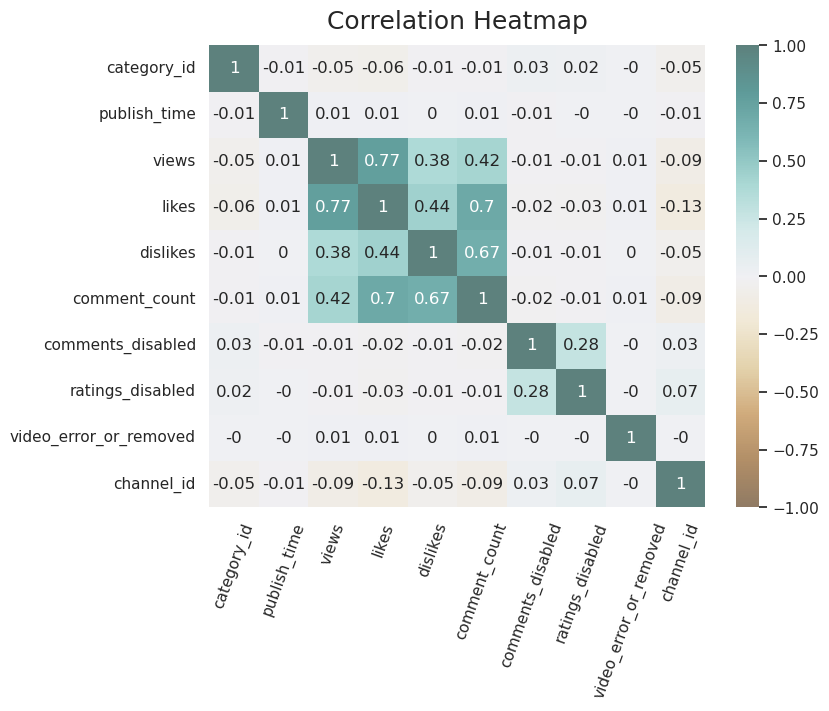

In [4]:
sns.set()
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(videos_df.corr().round(decimals=2), vmin=-1, vmax=1, annot=True, cmap='BrBG', alpha=.6)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
xtick = heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=70)

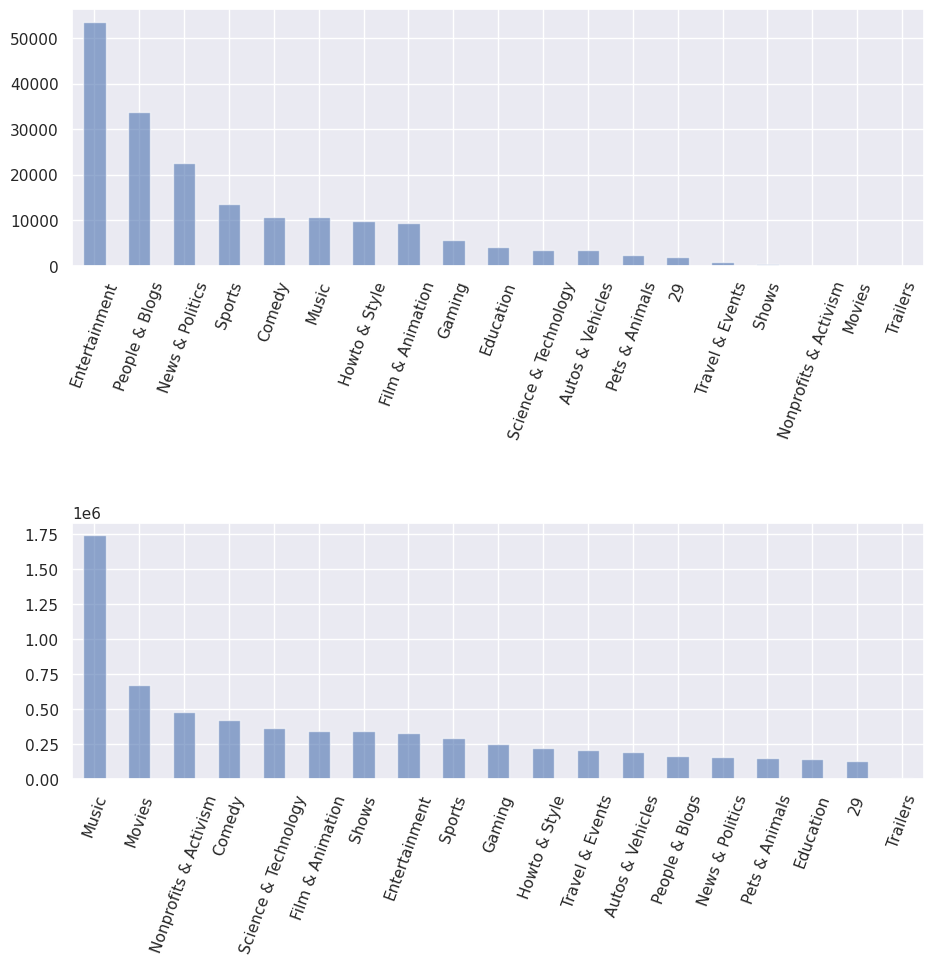

In [35]:
plt.rcParams['figure.figsize'] = [11, 10]
fig, axs = plt.subplots(2,1)

ax = videos_df.value_counts('category').plot.bar(ax=axs[0], rot=70, alpha=.6)
ax.xaxis.label.set_visible(False)

avg_views_category = videos_df.groupby('category')['views'].mean().sort_values(ascending=False)
ax = avg_views_category.plot.bar(ax=axs[1], rot=70, alpha=.6)
ax.xaxis.label.set_visible(False)

fig.subplots_adjust(hspace=1)
# ax.xaxis.label.set_visible(False)


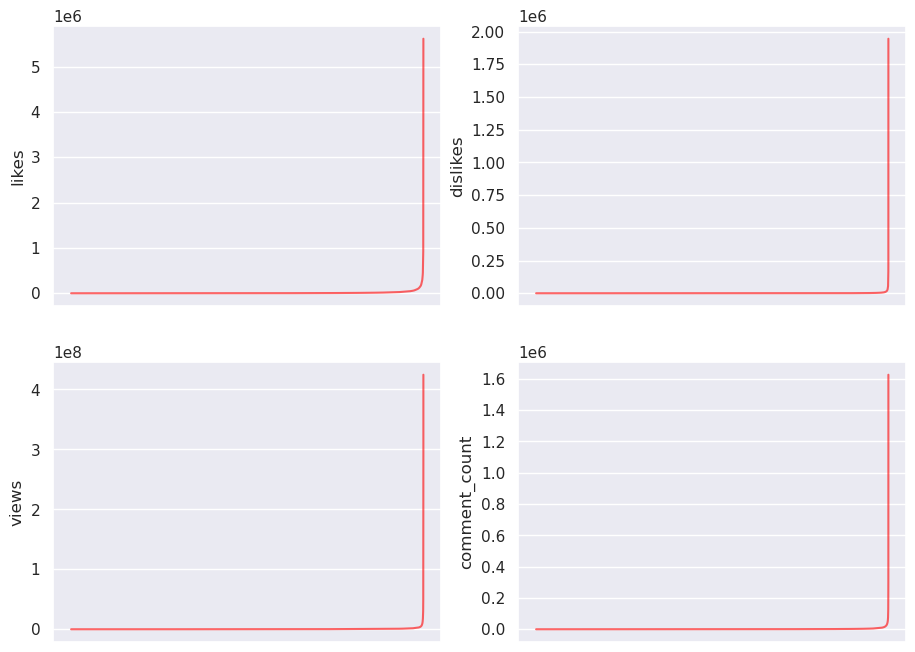

In [6]:
plt.rcParams['figure.figsize'] = [11, 8]
fig, axs = plt.subplots(2,2)

ax = videos_df["likes"].sort_values().reset_index(drop=True).plot(ax=axs[0][0], ylabel='likes', xticks=[], alpha=.6, color='red')
ax = videos_df["dislikes"].sort_values().reset_index(drop=True).plot(ax=axs[0][1], ylabel='dislikes', xticks=[], alpha=.6, color='red')
ax = videos_df['views'].sort_values().reset_index(drop=True).plot(ax=axs[1][0], ylabel='views', xticks=[], alpha=.6, color='red')
ax = videos_df['comment_count'].sort_values().reset_index(drop=True).plot(ax=axs[1][1], ylabel='comment_count', xticks=[], alpha=.6, color='red')

# axs[0][0].axvline(len(videos_df)*0.97, color='red', linestyle='--')
# axs[0][0].text(len(videos_df)*0.97,0,'97%')

## Παρατηρήσεις

Από τα παραπάνω γραφήματα παρατηρούμε τα εξής:

- **Υπάρχει όντως συσχέτιση μεταξύ views - likes - dislikes - comment_count**: Όπως ήταν αναμενόμενο, τα χαρακτηριστικά έχουν μεγάλη συσχέτιση. Επομένως μπορούμε να τα χρησιμοποιήσουμε για να εκπαιδεύσουμε τα μοντέλα μας αλλά σε πραγματικές καταστάσεις δεν θα είναι γνωστά πριν την δημοσίευση του βίντεο. 
- **Τα βίντεο από τις κατηγορίες *Entertaiment, People&Blogs, News&Politics, Sports* και *Comedy* είναι τα πιο δημοφιλή**
- **Ο αριθμός των βίντεο με πολλά views/likes/dislikes/comment_count είναι μικρός**

## Task 1 Ανάλυση δημοφιλών βίντεο

Για την ανάλυση θα μας απασχολήσουν μόνο τα πιο δημοφιλή βίντεο. Με βάση την κατανομή των βίντεο ως προς τις προβολές που είδαμε προηγουμένως θα κρατήσουμε μόνο όσα βίντεο ξεπερνούν τις 1.000.000 προβολές. 10965



In [7]:
top_videos = videos_df['views'].gt(100000)
top_videos = videos_df[top_videos]

from sklearn.feature_extraction.text import CountVectorizer

stopword_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('russian') + stopwords.words('portuguese') + stopwords.words('german')
stopword_list += ['youtube', 'video', 'videos', 'like', 'subscribe', 'facebook', 'instagram']

# vectorizer = CountVectorizer(max_df=0.8, max_features=5, token_pattern=r'(?u)\b[A-Za-z]+\b', stop_words=stopword_list)
# for category in top_videos['category'].unique():
#     category_videos = top_videos[top_videos['category'] == category]
#     if category_videos.shape[0] < 100:
#         continue
#     vectorizer.fit(category_videos['tags'])
#     print(category, vectorizer.get_feature_names())

from nltk.tokenize import RegexpTokenizer

words_per_category = {}
tokenizer = RegexpTokenizer(r'\w+')
for category in top_videos['category'].unique():
    category_videos = videos_df[videos_df['category'] == category]
    word_views = {}
    word_freq = {}
    for index, row in category_videos.iterrows():
        tokens = tokenizer.tokenize(row['tags'].lower())
        for token in tokens:
            if len(token) < 3:
                continue
            word_views[token] = word_views.get(token, 0) + int(row['views'])
            word_freq[token] = word_freq.get(token, 0) + 1
    words = {}
    for word, views in word_views.items():
        if word_freq[word] > 100:
            words[word] = float(views)/word_freq[word]

    sorted_words = sorted(words.items(), key=lambda item: item[1], reverse=True)
    best_words = []
    for word in sorted_words:
        if word[1] > 100000:
            best_words.append(word[0])
        if len(best_words) == 10:
            break
    words_per_category[category] = {}
    words_per_category[category]["tags"] = best_words
            
            
print("*****")


tokenizer = RegexpTokenizer(r'\w+')
for category in top_videos['category'].unique():
    category_videos = videos_df[videos_df['category'] == category]
    word_views = {}
    word_freq = {}
    for index, row in category_videos.iterrows():
        tokens = tokenizer.tokenize(row['title'].lower())
        for token in tokens:
            if len(token) < 3:
                continue
            word_views[token] = word_views.get(token, 0) + int(row['views'])
            word_freq[token] = word_freq.get(token, 0) + 1
    words = {}
    for word, views in word_views.items():
        if word_freq[word] > 100:
            words[word] = float(views)/word_freq[word]

    sorted_words = sorted(words.items(), key=lambda item: item[1], reverse=True)
    best_words = []
    for word in sorted_words:
        if word[1] > 100000:
            best_words.append(word[0])
        if len(best_words) == 10:
            break
    words_per_category[category]["title"] = best_words
            
            
            
print("*****")


tokenizer = RegexpTokenizer(r'\w+')
for category in top_videos['category'].unique():
    category_videos = videos_df[videos_df['category'] == category]
    word_views = {}
    word_freq = {}
    for index, row in category_videos.iterrows():
        tokens = tokenizer.tokenize(row['description'].lower())
        for token in tokens:
            if len(token) < 3:
                continue
            word_views[token] = word_views.get(token, 0) + int(row['views'])
            word_freq[token] = word_freq.get(token, 0) + 1
    words = {}
    for word, views in word_views.items():
        if word_freq[word] > 100:
            words[word] = float(views)/word_freq[word]

    sorted_words = sorted(words.items(), key=lambda item: item[1], reverse=True)
    best_words = []
    for word in sorted_words:
        if word[1] > 100000:
            best_words.append(word[0])
        if len(best_words) == 10:
            break
    words_per_category[category]["description"] = best_words

*****
*****


In [8]:
videos_df['top_trend'] = videos_df['views'].gt(100000).astype(int)


################## SLOW ##################
def grid_train_classifiers(classifiers, X_train, y_train, X_test, y_test, parameters):
    accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
    base_params = {}
    resultsacc = {}
    for name, clf in classifiers.items():
        param_grid = {name + "__" + k: v for k,v in parameters[name].items()}
        param_grid.update(base_params)
        pipe = Pipeline(steps=[(name, clf)], memory='tmp')
        estimator = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring=accuracy_scorer, n_jobs=-1)
        estimator.fit(X_train, y_train)
        preds = estimator.predict(X_test)
        resultsacc[name] = estimator.best_params_
        print(name, estimator.best_params_)
    return resultsacc

def train_classifiers(classifiers, X_train, y_train, X_test, y_test):
    accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)
    resultsacc = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)
        resultsacc[name] = accuracy_score(y_test, preds)
        print(name, resultsacc[name])
    return resultsacc


In [15]:
# CLassification using numerical features ('unfair')

# Create a pseudo-label
X = videos_df[['likes', 'dislikes', 'comment_count', 'category_id']]
y = videos_df['top_trend']
print(y.value_counts())


# We don't need PCA since we have very few dimensions
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train , test_size=0.20, stratify=y_train)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)


models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machines': LinearSVC(),
    'Decision Trees': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbor': KNeighborsClassifier(),
    'MLP': MLPClassifier(),
    "Dummy": DummyClassifier()
}

parameters = {
    "Dummy": {"strategy": ["most_frequent", "prior", "stratified", "uniform", "constant"]},
    "K-Nearest Neighbor": {"n_neighbors": np.arange(3, 30, 5)}, 
    "Naive Bayes": {}, 
    "Logistic Regression": {"penalty" : ["l1", "l2", "none"]},
    "MLP": {"hidden_layer_sizes": np.arange(50, 300, 50)},
    "Support Vector Machines": {"penalty": ['l1', 'l2'], "loss": ["hinge", "squared_hinge"]},
    "Decision Trees": {"criterion": ["gini", "entropy", "log_loss"]},
}


grid_train_classifiers(models, X_train, y_train, X_test, y_test, parameters)

0    107081
1     79580
Name: top_trend, dtype: int64


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, i

Logistic Regression {'Logistic Regression__penalty': 'none'}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 272, in fit
    s

Support Vector Machines {'Support Vector Machines__loss': 'hinge', 'Support Vector Machines__penalty': 'l2'}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    

Decision Trees {'Decision Trees__criterion': 'entropy'}
Naive Bayes {}
K-Nearest Neighbor {'K-Nearest Neighbor__n_neighbors': 23}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLP {'MLP__hidden_layer_sizes': 200}
Dummy {'Dummy__strategy': 'most_frequent'}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py", line 206, in fit
    "Constan

{'Logistic Regression': {'Logistic Regression__penalty': 'none'},
 'Support Vector Machines': {'Support Vector Machines__loss': 'hinge',
  'Support Vector Machines__penalty': 'l2'},
 'Decision Trees': {'Decision Trees__criterion': 'entropy'},
 'Naive Bayes': {},
 'K-Nearest Neighbor': {'K-Nearest Neighbor__n_neighbors': 23},
 'MLP': {'MLP__hidden_layer_sizes': 200},
 'Dummy': {'Dummy__strategy': 'most_frequent'}}

In [16]:
# Using best parameters
models = {
    'Logistic Regression': LogisticRegression(penalty='none'),
    'Support Vector Machines': LinearSVC(loss='hinge', penalty='l2'),
    'Decision Trees': DecisionTreeClassifier(criterion='entropy'),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=28),
    'MLP': MLPClassifier(hidden_layer_sizes=150),
    "Dummy": DummyClassifier(),
}

train_classifiers(models, X_train, y_train, X_val, y_val)


####
# Support Vector Machines 0.8090135940534386
# Decision Trees 0.8151744458581665
# Naive Bayes 0.7491127034085582
# K-Nearest Neighbor 0.8626531842228621
# MLP 0.8581664769302886
# Dummy 0.5736623585347888

Logistic Regression 0.8001741110292641


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Support Vector Machines 0.8090135940534386
Decision Trees 0.8151744458581665
Naive Bayes 0.7491127034085582
K-Nearest Neighbor 0.8626531842228621
MLP 0.8581664769302886
Dummy 0.5736623585347888


{'Logistic Regression': 0.8001741110292641,
 'Support Vector Machines': 0.8090135940534386,
 'Decision Trees': 0.8151744458581665,
 'Naive Bayes': 0.7491127034085582,
 'K-Nearest Neighbor': 0.8626531842228621,
 'MLP': 0.8581664769302886,
 'Dummy': 0.5736623585347888}

In [18]:
stopword_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('russian') + stopwords.words('portuguese') + stopwords.words('german')

videos_df['description'] = videos_df['description'].fillna(" ")
videos_df['text_features'] = videos_df[['description', 'title', 'tags']].agg(' | '.join, axis=1)

vectorizer = TfidfVectorizer(stop_words=stopword_list, max_features=256, min_df=10, token_pattern=r'(?u)\b[A-Za-z]+\b')
X = vectorizer.fit_transform(videos_df['text_features']).toarray()
y = videos_df['top_trend']

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train , test_size=0.20, stratify=y_train)

from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)
print("@")
models = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machines': LinearSVC(),
    'Decision Trees': DecisionTreeClassifier(),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbor': KNeighborsClassifier(),
    'MLP': MLPClassifier(),
    "Dummy": DummyClassifier(),
}

parameters = {
    "Dummy": {"strategy": ["most_frequent", "prior", "stratified", "uniform", "constant"]},
    "K-Nearest Neighbor": {"n_neighbors": np.arange(3, 30, 5)}, 
    "Naive Bayes": {}, 
    "Logistic Regression": {"penalty" : ["l1", "l2", "none"]},
    "MLP": {"hidden_layer_sizes": np.arange(50, 300, 50)},
    "Support Vector Machines": {"penalty": ['l1', 'l2'], "loss": ["hinge", "squared_hinge"]},
    "Decision Trees": {"criterion": ["gini", "entropy", "log_loss"]},
}


grid_train_classifiers(models, X_train, y_train, X_test, y_test, parameters)


@


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, i

Logistic Regression {'Logistic Regression__penalty': 'none'}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 272, in fit
    s

Support Vector Machines {'Support Vector Machines__loss': 'squared_hinge', 'Support Vector Machines__penalty': 'l2'}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 942, in fit
    

Decision Trees {'Decision Trees__criterion': 'entropy'}
Naive Bayes {}
K-Nearest Neighbor {'K-Nearest Neighbor__n_neighbors': 3}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: 

MLP {'MLP__hidden_layer_sizes': 250}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Dummy {'Dummy__strategy': 'most_frequent'}


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/dummy.py", line 206, in fit
    "Constan

{'Logistic Regression': {'Logistic Regression__penalty': 'none'},
 'Support Vector Machines': {'Support Vector Machines__loss': 'squared_hinge',
  'Support Vector Machines__penalty': 'l2'},
 'Decision Trees': {'Decision Trees__criterion': 'entropy'},
 'Naive Bayes': {},
 'K-Nearest Neighbor': {'K-Nearest Neighbor__n_neighbors': 3},
 'MLP': {'MLP__hidden_layer_sizes': 250},
 'Dummy': {'Dummy__strategy': 'most_frequent'}}

In [19]:

# Using best parameters
models = {
    'Logistic Regression': LogisticRegression(penalty='l2'),
    'Support Vector Machines': LinearSVC(loss='squared_hinge', penalty='l2'),
    'Decision Trees': DecisionTreeClassifier(criterion='gini'),
    'Naive Bayes': GaussianNB(),
    'K-Nearest Neighbor': KNeighborsClassifier(n_neighbors=8),
    'MLP': MLPClassifier(hidden_layer_sizes=150),
    "Dummy": DummyClassifier(strategy='most_frequent'),
}
# X_train = X_train.toarray()
# X_val = X_val.toarray()
train_classifiers(models, X_train, y_train, X_val, y_val)

# Logistic Regression 0.6798031206053706
# Support Vector Machines 0.6798366034956137
# Decision Trees 0.6947364896537869
# Naive Bayes 0.6340654925333155
# K-Nearest Neighbor 0.7302283533114579
# MLP 0.7301948704212148
# Dummy 0.5736623585347888



Logistic Regression 0.6798031206053706
Support Vector Machines 0.6798366034956137
Decision Trees 0.6947364896537869
Naive Bayes 0.6340654925333155
K-Nearest Neighbor 0.7302283533114579
MLP 0.7301948704212148
Dummy 0.5736623585347888


/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'Logistic Regression': 0.6798031206053706,
 'Support Vector Machines': 0.6798366034956137,
 'Decision Trees': 0.6947364896537869,
 'Naive Bayes': 0.6340654925333155,
 'K-Nearest Neighbor': 0.7302283533114579,
 'MLP': 0.7301948704212148,
 'Dummy': 0.5736623585347888}

In [20]:
from sklearn.metrics import mean_absolute_error
def grid_train_regressors(regressors, X_train, y_train, X_test, y_test, parameters):
    base_params = {}
    resultsacc = {}
    for name, regr in regressors.items():
        print(name)
        param_grid = {name + "__" + k: v for k,v in parameters[name].items()}
        param_grid.update(base_params)
        pipe = Pipeline(steps=[(name, regr)], memory='tmp')
        estimator = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring="neg_mean_absolute_error", n_jobs=-1)
        estimator.fit(X_train, y_train)
        preds = estimator.predict(X_test)
        resultsacc[name] = estimator.best_params_
        print(name, estimator.best_params_)
    return resultsacc

def train_regressors(regressors, X_train, y_train, X_test, y_test):
    resultsacc = {}
    for name, regr in regressors.items():
        regr.fit(X_train, y_train)
        preds = regr.predict(X_test)
        resultsacc[name] = mean_absolute_error(y_test, preds)
        print(name, resultsacc[name])
    return resultsacc


In [29]:
# 'Unfair' regression
# threshold = min(videos_df.sort_values('views', ascending=False).head(round(len(videos_df)*0.40))['views'])

# Create a pseudo-label
X = videos_df[['likes', 'dislikes', 'comment_count', 'category_id']]
X = X.reset_index(drop=True)
y = videos_df['views'].reset_index(drop=True)


from verstack.stratified_continuous_split import scsplit # pip install verstack
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import linear_model
from sklearn.dummy import DummyRegressor

X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = scsplit(X, y, stratify=y, test_size=0.2)

# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)
# X_val = ss.transform(X_val)


models = {
    "Decision Tree": tree.DecisionTreeRegressor(),
    "MLP Regressor": MLPRegressor(),
    "GradientBoosting Regressor": GradientBoostingRegressor(),
    "Linear Regressor": LinearRegression(),
    "Dummy": DummyRegressor()
}

parameters = {
    "Dummy": {"strategy": ['mean', 'median', 'quantile', 'constant']},
    "Decision Tree": {"criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"]}, 
    "Linear Regressor": {}, 
    "MLP Regressor": {"hidden_layer_sizes": np.arange(50, 300, 50)},
    "GradientBoosting Regressor": {"loss": ["squared_error", "absolute_error", "huber", "quantile"], "n_estimators": [50, 100, 150, 200]},
}

grid_train_regressors(models, X_train, y_train, X_test, y_test, parameters)

Decision Tree
Decision Tree {'Decision Tree__criterion': 'friedman_mse'}
MLP Regressor
MLP Regressor {'MLP Regressor__hidden_layer_sizes': 200}
GradientBoosting Regressor
GradientBoosting Regressor {'GradientBoosting Regressor__loss': 'absolute_error', 'GradientBoosting Regressor__n_estimators': 200}
Linear Regressor
Linear Regressor {}
Dummy
Dummy {'Dummy__strategy': 'median'}


{'Decision Tree': {'Decision Tree__criterion': 'friedman_mse'},
 'MLP Regressor': {'MLP Regressor__hidden_layer_sizes': 200},
 'GradientBoosting Regressor': {'GradientBoosting Regressor__loss': 'absolute_error',
  'GradientBoosting Regressor__n_estimators': 200},
 'Linear Regressor': {},
 'Dummy': {'Dummy__strategy': 'median'}}

/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/data/home/cxypolop/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceW

In [30]:

# Using best parameters

models = {
    "Decision Tree": tree.DecisionTreeRegressor(criterion='squared_error'),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=50),
    "GradientBoosting Regressor": GradientBoostingRegressor(loss='squared_error', n_estimators=50),
    "Linear Regressor": LinearRegression(),
    'Dummy Regressor': DummyRegressor(strategy='median')
}

train_regressors(models, X_train, y_train, X_val, y_val)


# Decision Tree 245355.4500280856
# MLP Regressor 256152.78354478683
# GradientBoosting Regressor 212219.6590289855
# Linear Regressor 292510.5686836164
# Dummy Regressor 320602.48905793804


Decision Tree 245355.4500280856
MLP Regressor 256152.78354478683
GradientBoosting Regressor 212219.6590289855
Linear Regressor 292510.5686836164
Dummy Regressor 320602.48905793804


{'Decision Tree': 245355.4500280856,
 'MLP Regressor': 256152.78354478683,
 'GradientBoosting Regressor': 212219.6590289855,
 'Linear Regressor': 292510.5686836164,
 'Dummy Regressor': 320602.48905793804}

In [31]:
stopword_list = stopwords.words('english') + stopwords.words('french') + stopwords.words('russian') + stopwords.words('portuguese') + stopwords.words('german')

videos_df['text_features'] = videos_df[['description', 'title', 'tags']].agg(' | '.join, axis=1)

vectorizer = TfidfVectorizer(stop_words=stopword_list, max_features=256, min_df=10, token_pattern=r'(?u)\b[A-Za-z]+\b')
X = pd.DataFrame(vectorizer.fit_transform(videos_df['text_features']).toarray())
y = videos_df['views'].reset_index(drop=True)


from verstack.stratified_continuous_split import scsplit # pip install verstack
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn import linear_model
from sklearn.dummy import DummyRegressor
from sklearn.decomposition import PCA

pca = PCA(n_components=100)

X_train, X_test, y_train, y_test = scsplit(X, y, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = scsplit(X, y, stratify=y, test_size=0.2)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
X_val = X_val.to_numpy()

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)



ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)
X_val = ss.transform(X_val)



models = {
    "Decision Tree": tree.DecisionTreeRegressor(),
    "MLP Regressor": MLPRegressor(),
    "GradientBoosting Regressor": GradientBoostingRegressor(),
    "Linear Regressor": LinearRegression(),
    "Dummy": DummyRegressor()
}

parameters = {
    "Dummy": {"strategy": ['mean', 'median', 'quantile', 'constant']},
    "Decision Tree": {"criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"]}, 
    "Linear Regressor": {}, 
    "MLP Regressor": {"hidden_layer_sizes": np.arange(50, 300, 50)},
    "GradientBoosting Regressor": {"loss": ["squared_error", "absolute_error", "huber", "quantile"], "n_estimators": [50, 100, 150, 200]},
}
print("Starting")
grid_train_regressors(models, X_train, y_train, X_test, y_test, parameters)

Starting
Decision Tree


KeyboardInterrupt: 

In [32]:
##### # Using best parameters
models = {
    "Decision Tree": tree.DecisionTreeRegressor(criterion='squared_error'),
    "MLP Regressor": MLPRegressor(hidden_layer_sizes=50),
    "GradientBoosting Regressor": GradientBoostingRegressor(loss='absolute_error', n_estimators=200),
    "Linear Regressor": LinearRegression(),
    'Dummy Regressor': DummyRegressor(strategy='median')
}

train_regressors(models, X_train, y_train, X_val, y_val)

# Decision Tree 456535.0851702696
# MLP Regressor 406795.18831213214
# GradientBoosting Regressor 306359.96879698936
# Linear Regressor 442737.761831589
# Dummy Regressor 325875.4596603541



Decision Tree 456535.0851702696
MLP Regressor 406795.18831213214
GradientBoosting Regressor 306359.96879698936
Linear Regressor 442737.761831589
Dummy Regressor 325875.4596603541


{'Decision Tree': 456535.0851702696,
 'MLP Regressor': 406795.18831213214,
 'GradientBoosting Regressor': 306359.96879698936,
 'Linear Regressor': 442737.761831589,
 'Dummy Regressor': 325875.4596603541}